In [43]:
import nltk
import gensim
import numpy as np
import pandas as pd
import networkx as nx
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from gensim import corpora
from heapq import nlargest
from collections import Counter
from nltk.corpus import stopwords
from rouge_score import rouge_scorer
from nltk import sent_tokenize, word_tokenize
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Yoga\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
cnn_train = pd.read_csv('cnn_dailymail/train.csv')
cnn_test = pd.read_csv('cnn_dailymail/test.csv')
cnn_val = pd.read_csv('cnn_dailymail/validation.csv')

In [3]:
cnn_train.drop("id", axis=1, inplace=True)
cnn_test.drop("id", axis=1, inplace=True)
cnn_val.drop("id", axis=1, inplace=True)

## <center>Data Cleaning</center>

In [4]:
def remove_stopwords(text):
    # Tokenize the text into words
    words = text.split()

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Join the words back into cleaned text
    cleaned_text = ' '.join(words)

    return cleaned_text

In [5]:
cnn_train['cleaned_article'] = cnn_train['article'].apply(remove_stopwords)
cnn_train['cleaned_highlights'] = cnn_train['highlights'].apply(remove_stopwords)

In [6]:
cnn_test['cleaned_article'] = cnn_test['article'].apply(remove_stopwords)
cnn_test['cleaned_highlights'] = cnn_test['highlights'].apply(remove_stopwords)

In [7]:
cnn_val['cleaned_article'] = cnn_val['article'].apply(remove_stopwords)
cnn_val['cleaned_highlights'] = cnn_val['highlights'].apply(remove_stopwords)

## <center>Techniques</center>

### Luhn Method

In [8]:
def luhn_summarize(article, num_sentences):
    # Tokenize the article into sentences
    sentences = sent_tokenize(article)
    
    # Tokenize the entire article into words
    words = word_tokenize(article)
    
    # Calculate word frequencies using Counter
    word_frequencies = Counter(words)

    # Initialize a dictionary to store sentence scores
    sentence_scores = {}

    # Calculate scores for each sentence
    for sentence in sentences:
        # Tokenize the sentence into words and convert to lowercase
        for word in word_tokenize(sentence.lower()):
            # Check if the word is in the word frequencies
            if word in word_frequencies:
                # If the sentence is not in the scores dictionary, initialize it
                if sentence not in sentence_scores:
                    sentence_scores[sentence] = word_frequencies[word]
                else:
                    # If the sentence is already in the dictionary, add the word's frequency
                    sentence_scores[sentence] += word_frequencies[word]

    # Get the top 'num_sentences' sentences with the highest scores
    summary_sentences = nlargest(num_sentences, sentence_scores, key=sentence_scores.get)

    # Combine the selected sentences to create the summary
    summary = ' '.join(summary_sentences)
    
    return summary

In [9]:
# Apply Luhn Method to each article in the training dataset and store summaries
cnn_train['luhn_summary'] = cnn_train['cleaned_article'].apply(lambda x: luhn_summarize(x, num_sentences=3))

# Apply Luhn Method to each article in the testing dataset and store summaries
cnn_test['luhn_summary'] = cnn_test['cleaned_article'].apply(lambda x: luhn_summarize(x, num_sentences=3))

# Apply Luhn Method to each article in the validation dataset and store summaries
cnn_val['luhn_summary'] = cnn_val['cleaned_article'].apply(lambda x: luhn_summarize(x, num_sentences=3))

In [ ]:
# Save the results to new CSV files for each dataset
cnn_train.to_csv("cnn_train_with_luhn_summaries.csv", index=False)
cnn_test.to_csv("cnn_test_with_luhn_summaries.csv", index=False)
cnn_val.to_csv("cnn_val_with_luhn_summaries.csv", index=False)

In [10]:
# Define a function to calculate ROUGE scores
def calculate_rouge_scores(df):
    # Initialize the ROUGE scorer
    rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    # Lists to store the ROUGE scores
    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []

    for _, row in df.iterrows():
        reference_summary = row['cleaned_highlights']
        luhn_summary = row['luhn_summary']

        # Check if reference_summary or luhn_summary is None or empty
        if reference_summary is None or luhn_summary is None or reference_summary == "" or luhn_summary == "":
            # Append 0.0 for precision, recall, and fmeasure
            rouge1_scores.append([{'precision': 0.0, 'recall': 0.0, 'fmeasure': 0.0}])
            rouge2_scores.append([{'precision': 0.0, 'recall': 0.0, 'fmeasure': 0.0}])
            rougeL_scores.append([{'precision': 0.0, 'recall': 0.0, 'fmeasure': 0.0}])
            
        else:
            # Calculate ROUGE scores
            scores = rouge.score(luhn_summary, reference_summary)

            rouge1_scores.append([{
                'precision': round(scores['rouge1'].precision, 2),
                'recall': round(scores['rouge1'].recall, 2),
                'fmeasure': round(scores['rouge1'].fmeasure, 2)
            }])
            
            rouge2_scores.append([{
                'precision': round(scores['rouge2'].precision, 2),
                'recall': round(scores['rouge2'].recall, 2),
                'fmeasure': round(scores['rouge2'].fmeasure, 2)
            }])
            
            rougeL_scores.append([{
                'precision': round(scores['rougeL'].precision, 2),
                'recall': round(scores['rougeL'].recall, 2),
                'fmeasure': round(scores['rougeL'].fmeasure, 2)
            }])

    df['rouge1'] = rouge1_scores
    df['rouge2'] = rouge2_scores
    df['rougeL'] = rougeL_scores
    
    # Print the ROUGE scores for the first row for debugging
    print("Rouge1 Scores:", rouge1_scores[0])
    print("Rouge2 Scores:", rouge2_scores[0])
    print("RougeL Scores:", rougeL_scores[0])

In [11]:
# Calculate ROUGE scores for train dataset
calculate_rouge_scores(cnn_train)

Rouge1 Scores: [{'precision': 0.55, 'recall': 0.22, 'fmeasure': 0.32}]
Rouge2 Scores: [{'precision': 0.38, 'recall': 0.15, 'fmeasure': 0.22}]
RougeL Scores: [{'precision': 0.55, 'recall': 0.22, 'fmeasure': 0.32}]


In [12]:
# Calculate ROUGE scores for test dataset
calculate_rouge_scores(cnn_test)

Rouge1 Scores: [{'precision': 0.28, 'recall': 0.12, 'fmeasure': 0.16}]
Rouge2 Scores: [{'precision': 0.08, 'recall': 0.03, 'fmeasure': 0.05}]
RougeL Scores: [{'precision': 0.24, 'recall': 0.1, 'fmeasure': 0.14}]


In [13]:
# Calculate ROUGE scores for validation dataset
calculate_rouge_scores(cnn_val)

Rouge1 Scores: [{'precision': 0.5, 'recall': 0.26, 'fmeasure': 0.34}]
Rouge2 Scores: [{'precision': 0.38, 'recall': 0.2, 'fmeasure': 0.26}]
RougeL Scores: [{'precision': 0.45, 'recall': 0.24, 'fmeasure': 0.31}]


In [ ]:
# Save the train dataset with ROUGE scores
cnn_train.to_csv("cnn_test_with_rouge_scores.csv", index=False)

# Save the test dataset with ROUGE scores
cnn_test.to_csv("cnn_test_with_rouge_scores.csv", index=False)

# Save the validation dataset with ROUGE scores
cnn_val.to_csv("cnn_val_with_rouge_scores.csv", index=False)

### TextRank

In [34]:
def textrank_summarize(article, num_sentences):
    # Tokenize the article into sentences
    sentences = sent_tokenize(article)

    # Check if there are sentences to summarize
    if not sentences:
        return "No sentences to summarize"

    # Vectorize sentences using CountVectorizer
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(sentences)
    vectors = X.toarray()

    # Calculate cosine similarity between sentence vectors
    similarity_matrix = cosine_similarity(vectors, vectors)

    # Create a graph representation of sentences
    sentence_graph = nx.Graph()
    threshold = 0.2  # You can adjust this threshold based on your data
    for i in range(len(sentences)):
        for j in range(i + 1, len(sentences)):  # Avoid self-connecting and duplicate edges
            if similarity_matrix[i][j] >= threshold:
                sentence_graph.add_edge(i, j, weight=similarity_matrix[i][j])

    # Check if there are no edges in the sentence graph
    if len(sentence_graph.edges) == 0:
        return "Not enough connections for summarization"

    # Calculate TextRank scores
    scores = nx.pagerank(sentence_graph)

    # Sort sentences by their TextRank scores
    ranked_sentences = sorted(((scores[i], sentence) for i, sentence in enumerate(sentences)), reverse=True)

    # Get the top 'num_sentences' sentences for the summary
    summary_sentences = [sentence for score, sentence in ranked_sentences[:num_sentences]]

    # Combine selected sentences into the summary
    summary = ' '.join(summary_sentences)
    return summary

In [35]:
# Apply TextRank summarization to the train dataset
cnn_train['textrank_summary'] = cnn_train['cleaned_article'].apply(lambda x: textrank_summarize(x, num_sentences=3))

# Apply TextRank summarization to the test dataset
cnn_test['textrank_summary'] = cnn_test['cleaned_article'].apply(lambda x: textrank_summarize(x, num_sentences=3))

# Apply TextRank summarization to the validation dataset
cnn_val['textrank_summary'] = cnn_val['cleaned_article'].apply(lambda x: textrank_summarize(x, num_sentences=3))

KeyError: 0

In [ ]:
# Save the results to new CSV files
cnn_train.to_csv("cnn_train_with_textrank_summaries.csv", index=False)
cnn_test.to_csv("cnn_test_with_textrank_summaries.csv", index=False)
cnn_val.to_csv("cnn_val_with_textrank_summaries.csv", index=False)

### LexRank

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from lexrank import LexRank
from lexrank.mappings.stopwords import STOPWORDS
from heapq import nlargest
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import Counter

def lexrank_summarize(article, num_sentences):
    # Tokenize the article into sentences
    sentences = sent_tokenize(article)
    
    # Vectorize the sentences using TF-IDF
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(sentences)

    # Calculate similarity matrix using cosine similarity
    sentence_similarity_matrix = cosine_similarity(tfidf_matrix)

    # Apply LexRank
    lx = LexRank(sentences, stopwords=STOPWORDS['en'])
    summary = lx.get_summary(article, summary_size=num_sentences)

    # Combine the selected sentences to create the summary
    summary = ' '.join(summary)
    
    return summary

In [37]:
# Apply TextRank summarization to the train dataset
cnn_train['lexrank_summary'] = cnn_train['cleaned_article'].apply(lambda x: lexrank_summarize(x, num_sentences=3))

# Apply TextRank summarization to the test dataset
cnn_test['lexrank_summary'] = cnn_test['cleaned_article'].apply(lambda x: lexrank_summarize(x, num_sentences=3))

# Apply TextRank summarization to the validation dataset
cnn_val['lexrank_summary'] = cnn_val['cleaned_article'].apply(lambda x: lexrank_summarize(x, num_sentences=3))

ValueError: documents are not informative

### Latent Semantic Analysis

In [33]:
# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the article and highlights text
tfidf_matrix_article = tfidf_vectorizer.fit_transform(cnn_train['cleaned_article'])
tfidf_matrix_highlights = tfidf_vectorizer.fit_transform(cnn_train['cleaned_highlights'])

In [34]:
# Define the number of components (latent factors)
n_components = 100  

# Perform Truncated SVD on the TF-IDF matrices
lsa_article = TruncatedSVD(n_components)
lsa_highlights = TruncatedSVD(n_components)

lsa_matrix_article = lsa_article.fit_transform(tfidf_matrix_article)
lsa_matrix_highlights = lsa_highlights.fit_transform(tfidf_matrix_highlights)

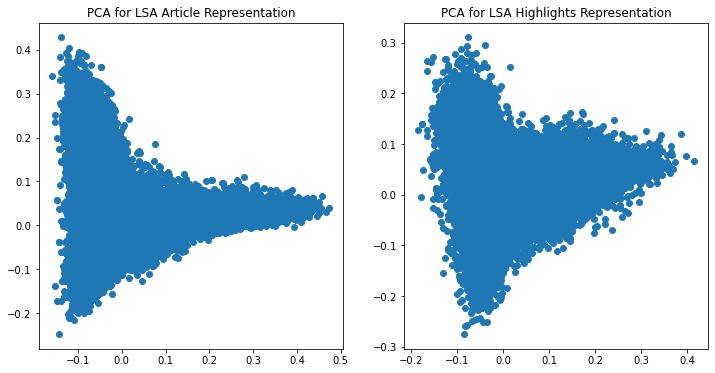

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


In [37]:
# Perform PCA on the LSA representations
pca_article = PCA(n_components=2)
pca_highlights = PCA(n_components=2)

pca_matrix_article = pca_article.fit_transform(lsa_matrix_article)
pca_matrix_highlights = pca_highlights.fit_transform(lsa_matrix_highlights)

# Plot the PCA results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(pca_matrix_article[:, 0], pca_matrix_article[:, 1])
plt.title('PCA for LSA Article Representation')

plt.subplot(1, 2, 2)
plt.scatter(pca_matrix_highlights[:, 0], pca_matrix_highlights[:, 1])
plt.title('PCA for LSA Highlights Representation')

plt.show()

In [38]:
# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the article and highlights text
tfidf_matrix_article = tfidf_vectorizer.fit_transform(cnn_test['cleaned_article'])
tfidf_matrix_highlights = tfidf_vectorizer.fit_transform(cnn_test['cleaned_highlights'])

In [39]:
# Define the number of components (latent factors)
n_components = 100  

# Perform Truncated SVD on the TF-IDF matrices
lsa_article = TruncatedSVD(n_components)
lsa_highlights = TruncatedSVD(n_components)

lsa_matrix_article = lsa_article.fit_transform(tfidf_matrix_article)
lsa_matrix_highlights = lsa_highlights.fit_transform(tfidf_matrix_highlights)

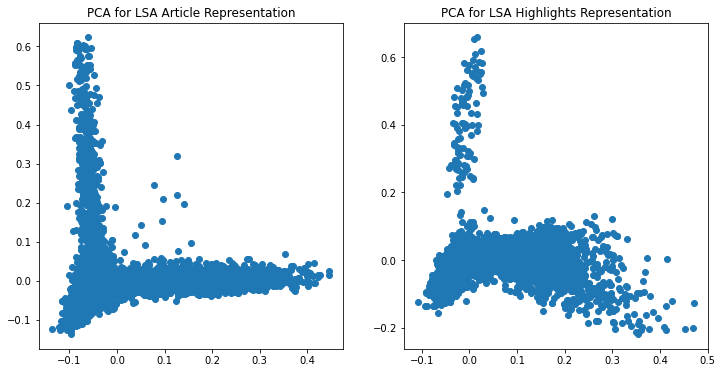

In [40]:
# Perform PCA on the LSA representations
pca_article = PCA(n_components=2)
pca_highlights = PCA(n_components=2)

pca_matrix_article = pca_article.fit_transform(lsa_matrix_article)
pca_matrix_highlights = pca_highlights.fit_transform(lsa_matrix_highlights)

# Plot the PCA results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(pca_matrix_article[:, 0], pca_matrix_article[:, 1])
plt.title('PCA for LSA Article Representation')

plt.subplot(1, 2, 2)
plt.scatter(pca_matrix_highlights[:, 0], pca_matrix_highlights[:, 1])
plt.title('PCA for LSA Highlights Representation')

plt.show()

In [41]:
# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the article and highlights text
tfidf_matrix_article = tfidf_vectorizer.fit_transform(cnn_val['cleaned_article'])
tfidf_matrix_highlights = tfidf_vectorizer.fit_transform(cnn_val['cleaned_highlights'])

In [42]:
# Define the number of components (latent factors)
n_components = 100  

# Perform Truncated SVD on the TF-IDF matrices
lsa_article = TruncatedSVD(n_components)
lsa_highlights = TruncatedSVD(n_components)

lsa_matrix_article = lsa_article.fit_transform(tfidf_matrix_article)
lsa_matrix_highlights = lsa_highlights.fit_transform(tfidf_matrix_highlights)

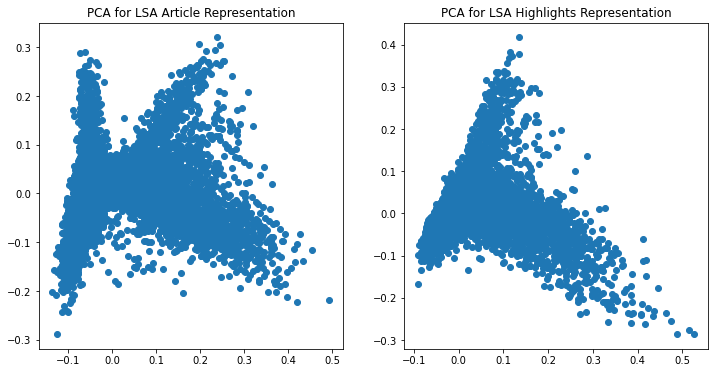

In [43]:
# Perform PCA on the LSA representations
pca_article = PCA(n_components=2)
pca_highlights = PCA(n_components=2)

pca_matrix_article = pca_article.fit_transform(lsa_matrix_article)
pca_matrix_highlights = pca_highlights.fit_transform(lsa_matrix_highlights)

# Plot the PCA results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(pca_matrix_article[:, 0], pca_matrix_article[:, 1])
plt.title('PCA for LSA Article Representation')

plt.subplot(1, 2, 2)
plt.scatter(pca_matrix_highlights[:, 0], pca_matrix_highlights[:, 1])
plt.title('PCA for LSA Highlights Representation')

plt.show()

### LsaSummarizer (Latent Semantic Analysis)

In [44]:
def lsa_summarize(article, num_sentences):
    # Tokenize the article into sentences
    sentences = sent_tokenize(article)
    
    # Tokenize the entire article into words
    words = word_tokenize(article)
    
    # Create a dictionary and a corpus
    dictionary = corpora.Dictionary([words])
    corpus = [dictionary.doc2bow(words)]
    
    # Create an LSA model
    num_topics = 2  # You can adjust the number of topics as needed
    lsa_model = gensim.models.LsiModel(corpus, id2word=dictionary, num_topics=num_topics)
    
    # Calculate LSA scores for each sentence
    sentence_scores = {}

    for sentence in sentences:
        # Tokenize the sentence into words and convert to lowercase
        sentence_words = word_tokenize(sentence.lower())
        
        # Calculate the LSA vector for the sentence
        sentence_bow = dictionary.doc2bow(sentence_words)
        lsa_vector = lsa_model[sentence_bow]
        
        # Calculate the LSA score as the sum of absolute values of vector components
        score = sum(abs(value) for _, value in lsa_vector)
        
        # Store the score for the sentence
        sentence_scores[sentence] = score

    # Get the top 'num_sentences' sentences with the highest scores
    summary_sentences = nlargest(num_sentences, sentence_scores, key=sentence_scores.get)

    # Combine the selected sentences to create the summary
    summary = ' '.join(summary_sentences)
    
    return summary

In [ ]:
# Apply LSA summarization to each article in the training dataset and store summaries
cnn_train['lsa_summary'] = cnn_train['cleaned_article'].apply(lambda x: lsa_summarize(x, num_sentences=3))

# Apply LSA summarization to each article in the testing dataset and store summaries
cnn_test['lsa_summary'] = cnn_test['cleaned_article'].apply(lambda x: lsa_summarize(x, num_sentences=3))

# Apply LSA summarization to each article in the validation dataset and store summaries
cnn_val['lsa_summary'] = cnn_val['cleaned_article'].apply(lambda x: lsa_summarize(x, num_sentences=3))

In [ ]:
# Define a function to calculate ROUGE scores
def calculate_rouge_scores(df):
    # Initialize the ROUGE scorer
    rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    # Lists to store the ROUGE scores
    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []

    for _, row in df.iterrows():
        reference_summary = row['cleaned_highlights']
        lsa_summary = row['lsa_summary']

        # Check if reference_summary or lsa_summary is None or empty
        if reference_summary is None or lsa_summary is None or reference_summary == "" or lsa_summary == "":
            # Append 0.0 for precision, recall, and fmeasure
            rouge1_scores.append({'precision': 0.0, 'recall': 0.0, 'fmeasure': 0.0})
            rouge2_scores.append({'precision': 0.0, 'recall': 0.0, 'fmeasure': 0.0})
            rougeL_scores.append({'precision': 0.0, 'recall': 0.0, 'fmeasure': 0.0})
        else:
            # Calculate ROUGE scores
            scores = rouge.score(luhn_summary, reference_summary)

            rouge1_scores.append({
                'precision': round(scores['rouge1'].precision, 2),
                'recall': round(scores['rouge1'].recall, 2),
                'fmeasure': round(scores['rouge1'].fmeasure, 2)
            })
            
            rouge2_scores.append({
                'precision': round(scores['rouge2'].precision, 2),
                'recall': round(scores['rouge2'].recall, 2),
                'fmeasure': round(scores['rouge2'].fmeasure, 2)
            })
            
            rougeL_scores.append({
                'precision': round(scores['rougeL'].precision, 2),
                'recall': round(scores['rougeL'].recall, 2),
                'fmeasure': round(scores['rougeL'].fmeasure, 2)
            })

    df['rouge1'] = rouge1_scores
    df['rouge2'] = rouge2_scores
    df['rougeL'] = rougeL_scores
    
    # Print the ROUGE scores for the first row for debugging
    print("Rouge1 Scores:", rouge1_scores[0])
    print("Rouge2 Scores:", rouge2_scores[0])
    print("RougeL Scores:", rougeL_scores[0])

In [ ]:
# Calculate ROUGE scores for train dataset
calculate_rouge_scores(cnn_train)

In [ ]:
# Calculate ROUGE scores for test dataset
calculate_rouge_scores(cnn_test)

In [ ]:
# Calculate ROUGE scores for validation dataset
calculate_rouge_scores(cnn_val)